In [3]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline

## Generazione dati
Generiamo $n$ samples da una distribuzione normale con valori dati di $\mu$ e  $\sigma$

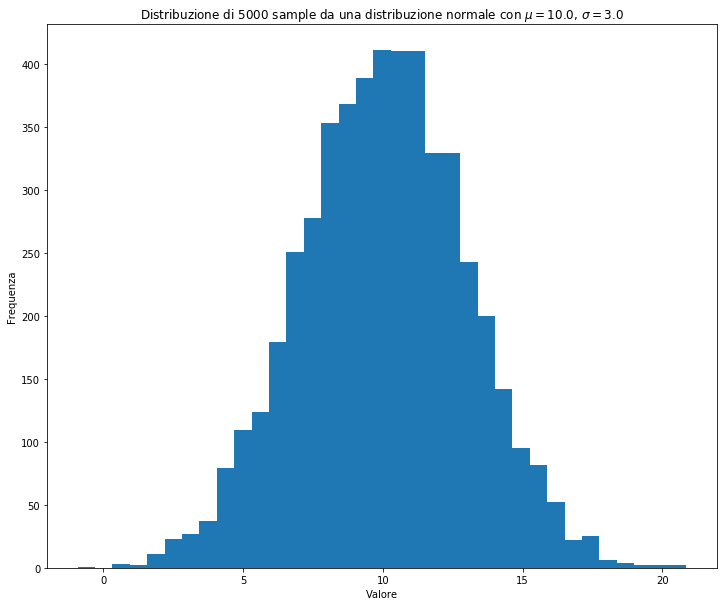

In [5]:
mu = 10
sigma = 3
n = 5000

mod=lambda t:np.random.normal(mu,sigma,t)

samples = mod(n)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.hist( samples,bins=35 ,)
ax.set_xlabel("Valore")
ax.set_ylabel("Frequenza")
ax.set_title("Distribuzione di {0:2d} sample da una distribuzione normale con $\mu={1:5.1f}$, $\sigma={2:5.1f}$".format(n,mu,sigma))
mu_obs=samples.mean()

## Modello bayesiano

Vogliamo stimare $\mu$ e $\sigma$ a partire dai dati, applicando MCMC. Nello specifico, vogliamo ottenere una sequenza di sample di

$$
p(\sigma,\mu|X)\propto p(X|\sigma,\mu)p(\sigma,\mu)=\prod_{i=1}^np(x_i|\sigma,\mu)p(\sigma,\mu)
$$

per semplicità, assumiamo di stimare $\mu$ come $$\overline{\mu}=\frac{1}{n}\sum_{i=1}^n x_i$$ che risulta pari a

In [6]:
avg=samples.mean()
print(avg)

10.029756798371398


Ne deriva che, limitatamente a $\sigma$, abbiamo

$$
p(\sigma|X,\overline{\mu})\propto p(X|\sigma,\overline{\mu})p(\sigma)=\prod_{i=1}^np(x_i|\sigma,\overline{\mu})p(\sigma)
$$

Assumendo sia la prior $p(\sigma)$ che la likelihood $p(x|\sigma,\overline{\mu})$ come gaussiane rispettivamente con media 0 e deviazione standard $\hat\sigma$ e media $\overline{\mu}$ e varianza $\sigma$, abbiamo che

\begin{equation}
p(\sigma|X,\overline{\mu})\propto \left(\prod_{i=1}^n\frac{1}{\sqrt{2\pi}\sigma}e^{-\dfrac{(x_i-\overline{\mu})^2}{2\sigma^2}}\right)\frac{1}{\sqrt{2\pi}\hat\sigma}e^{-\dfrac{\sigma^2}{2\hat\sigma^2}}\propto \sigma^{-n}e^{-\dfrac{\sigma^2}{2\hat\sigma^2}}\prod_{i=1}^ne^{-\dfrac{(x_i-\overline{\mu})^2}{2\sigma^2}}
\end{equation}

### Definizione della MC

Come distribuzione della probabilità di transizione $q(\sigma'|\sigma)$ assumiamo ad esempio una distribuzione normale con varianza unitaria

\begin{equation} 
q(\sigma | \sigma') = \frac{1}{\sqrt{2\pi}}e^{-\dfrac{(\sigma-\sigma')^2}{2}} 
\end{equation}

Si noti che $q(\sigma'|\sigma)=q(\sigma|\sigma')$, per cui possiamo applicare l'algoritmo di Metropolis


## Accettazione di $\sigma'$: 
Applicando l'algoritmo di Metropolis $\sigma'$ è accettato:

- se $$
\frac{p(\sigma'|X,\overline{\mu})}{p(\sigma|X,\overline{\mu})}>1
$$

- con probabilità $$
\frac{p(\sigma'|X,\overline{\mu})}{p(\sigma|X,\overline{\mu})}
$$
altrimenti

## Passaggio ai logaritmi
La condizione di accettazione può essere espressa applicando il logaritmo ai termini in gioco e passando a prior e likelihood, ottenendo che $\sigma'$ è accettato:

- se $$
\log p(X|\sigma',\overline{\mu})+\log p(\sigma')-p(X|\sigma,\overline{\mu})-p(\sigma)>0
$$

- con probabilità $$
\frac{p(\overline{\sigma}|X,\overline{\mu})}{p(\sigma|X,\overline{\mu})}
$$
altrimenti

Ricordando le definizioni di likelihood e prior considerate, si ottiene quindi che la condizione da verificare è
$$
-n\log\sigma'-\sum_{i=1}^n\dfrac{(x_i-\overline{\mu})^2}{2\sigma'^2}-\dfrac{\sigma'^2}{2\hat\sigma^2}+n\log\sigma+\sum_{i=1}^n\dfrac{(x_i-\overline{\mu})^2}{2\sigma^2}+\dfrac{\sigma^2}{2\hat\sigma^2}>0
$$


In [82]:
# Sampling dalla distribuzione di transizione 

def transition(x):
    x_new = np.random.normal(x,1,(1,))[0]
    if x_new>0:
        return x_new
    else:
        return x

# Proporzionale al logaritmo della probabilità a priori
def log_prior(sigma):
    return -(sigma/sigma_hat)**2/2.0

# Proporzionale al logaritmo della likelihood dei dati
def log_likelihood(sigma,samples):
    n = len(samples)
    return -n*np.log(sigma)-np.sum((samples-avg)**2)/(2*sigma**2)

# Test di accettazione del nuovo valore
def acc(sigma_new, sigma):
    first_term = log_likelihood(sigma_new,samples)+log_prior(sigma_new)
    second_term = log_likelihood(sigma,samples)+log_prior(sigma)
    test_val = first_term-second_term
    if test_val>0:
        return True
    else:
        accept=np.random.uniform(0,1)
        return (accept < (np.exp(test_val)))

# Algoritmo di Metropolis
def metropolis(param_init,iterations):
    sigma = param_init
    values = []
    accepted_idx = []
    rejected_idx = []   
    for i in range(iterations):
        sigma_new =  transition(sigma) 
        values.append(sigma_new)
        if acc(sigma_new,sigma):            
            sigma = sigma_new
            accepted_idx.append(i)
        else:
            rejected_idx.append(i)              
    return np.array(values), np.array(accepted_idx), np.array(rejected_idx)

### Esegue l'algoritmo

In [83]:
sigma_init = 5
iterations = 10000
sigma_hat = 5
values, accepted_idx, rejected_idx = metropolis(sigma_init, iterations)

In [84]:
print('Numero valori generati: {0:3d}'.format(values.shape[0]))
print('Numero valori accettati: {0:3d}'.format(accepted_idx.shape[0]))
print('Numero valori respinti: {0:3d}'.format(rejected_idx.shape[0]))

Numero valori generati: 10000
Numero valori accettati: 364
Numero valori respinti: 9636


### Traccia

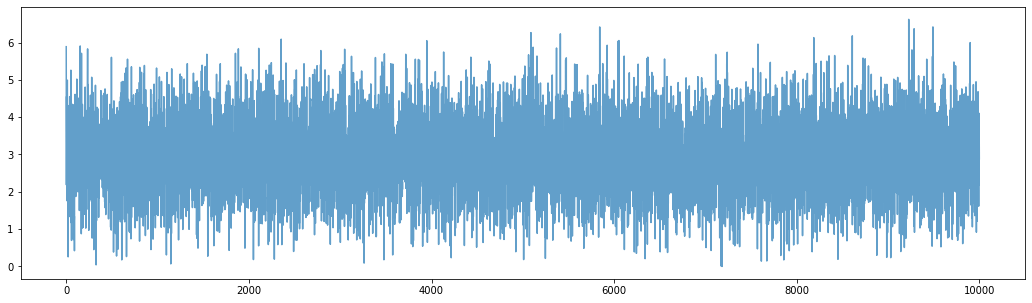

In [85]:
fig=plt.figure(figsize=(18,5))
plt.plot(values, alpha=.7)
plt.show()

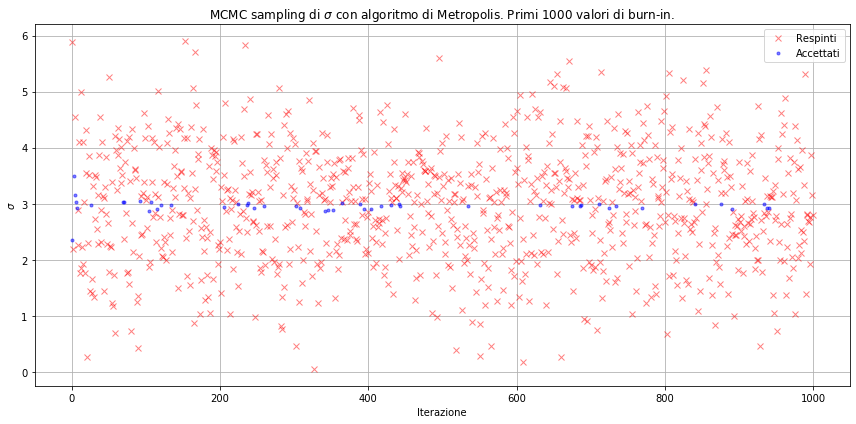

In [86]:
burn = int(0.1*iterations)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
rejected_to_plot = rejected_idx[np.where(rejected_idx<burn)]
accepted_to_plot = accepted_idx[np.where(accepted_idx<burn)]
ax.plot( rejected_to_plot, values[rejected_to_plot], 'rx', label='Respinti',alpha=0.5)
ax.plot( accepted_to_plot, values[accepted_to_plot], 'b.', label='Accettati',alpha=0.5)
ax.set_xlabel("Iterazione")
ax.set_ylabel("$\sigma$")
ax.set_title("MCMC sampling di $\sigma$ con algoritmo di Metropolis. Primi {0:3d} valori di burn-in.".format(burn))
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

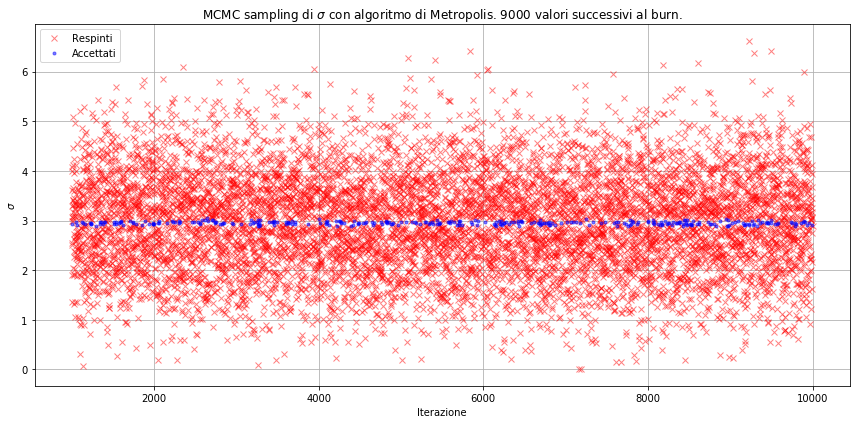

In [87]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
rejected_to_plot_after_burn = rejected_idx[np.where(rejected_idx>burn)]
accepted_to_plot_after_burn = accepted_idx[np.where(accepted_idx>burn)]
ax.plot( rejected_to_plot_after_burn, values[rejected_to_plot_after_burn], 'rx', label='Respinti',alpha=0.5)
ax.plot( accepted_to_plot_after_burn, values[accepted_to_plot_after_burn], 'b.', label='Accettati',alpha=0.5)
ax.set_xlabel("Iterazione")
ax.set_ylabel("$\sigma$")
ax.set_title("MCMC sampling di $\sigma$ con algoritmo di Metropolis. {0:3d} valori successivi al burn.".format(iterations-burn))
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

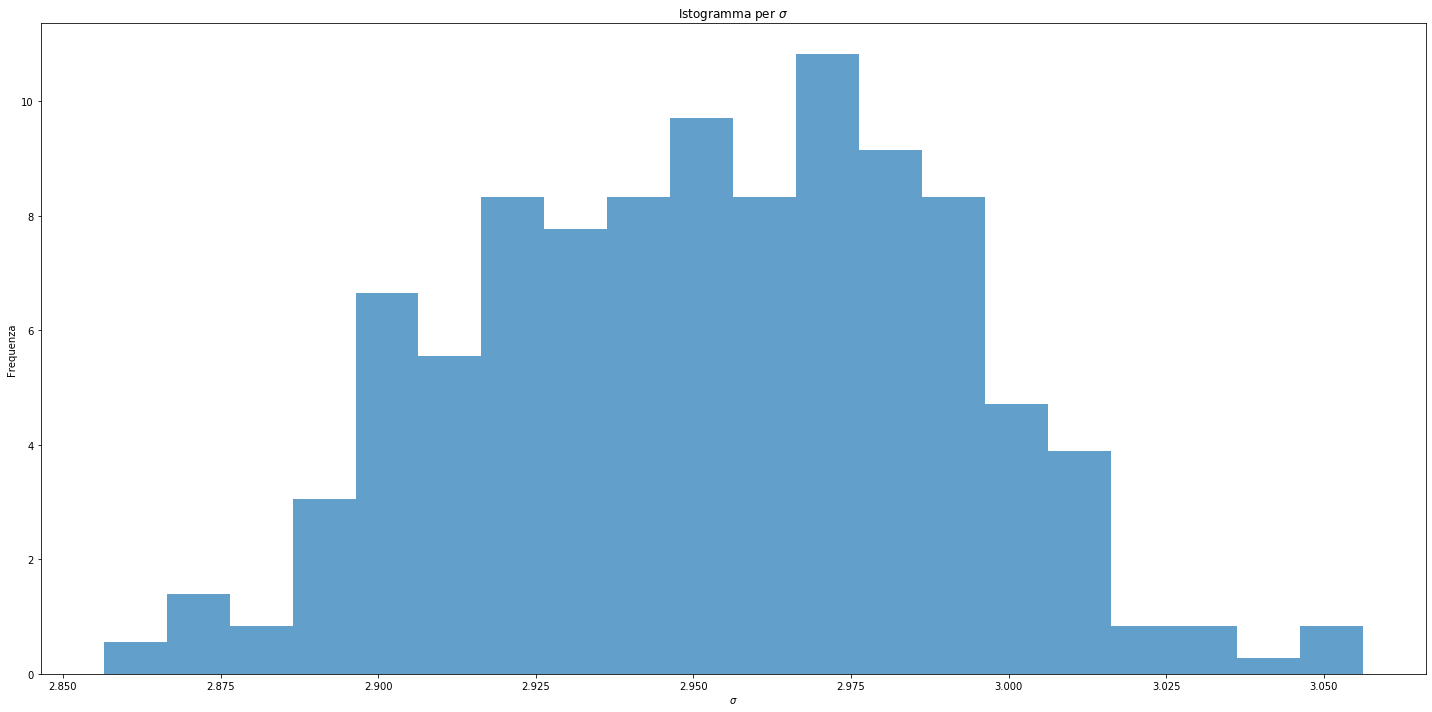

In [13]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.hist(values[accepted_to_plot_after_burn], bins=20 ,density=True, alpha=.7)
ax.set_ylabel("Frequenza")
ax.set_xlabel("$\sigma$")
ax.set_title("Istogramma per $\sigma$")
fig.tight_layout()
plt.show()


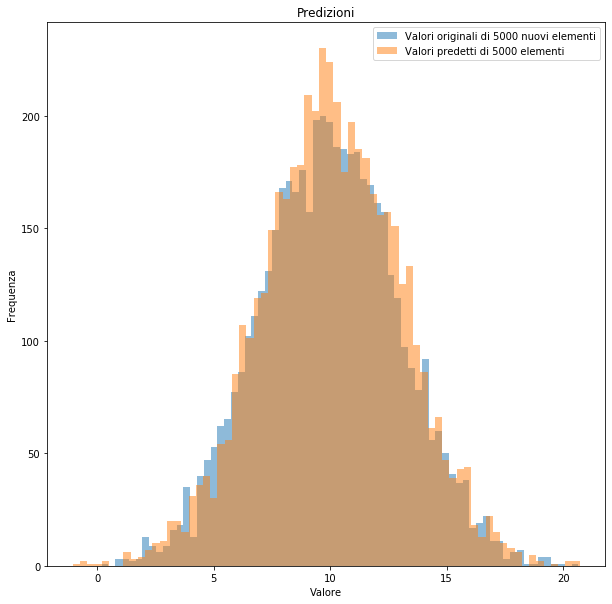

In [14]:
m = 5000
sigma_post=values[accepted_to_plot_after_burn].mean()
mod_emp=lambda t:np.random.normal(mu_obs,sigma_post,t)
observations = mod(m)
predictions = mod_emp(m)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observations,bins=70 ,label="Valori originali di {0:3d} nuovi elementi".format(m), alpha=.5)
ax.hist( predictions,bins=70 ,label="Valori predetti di {0:3d} elementi".format(m), alpha=.5)
ax.set_xlabel("Valore")
ax.set_ylabel("Frequenza")
ax.set_title("Predizioni")
ax.legend()
plt.show()

Vogliamo ora stimare entrambi $\mu$ e $\sigma$ a partire dai dati, applicando MCMC. La sequenza di sample sarà estratta da

$$
p(\mu,\sigma|X)\propto p(X|\mu,\sigma)p(\mu,\sigma)=\prod_{i=1}^np(x_i|\mu,\sigma)p(\mu,\sigma)
$$

Ne deriva che, facendo le ipotesi semplificative seguenti:
- la likelihood $p(x|\sigma,\mu)$ è una gaussiana
- la prior $p(\mu, \sigma)$ è una gaussiana bivariata, con medie $\mu_m, \mu_d=0$ e matrice di covarianza diagonale, con deviazioni standard $\sigma_m, \sigma_d$ 


abbiamo

\begin{equation}
p(\mu, \sigma|X)\propto \left(\prod_{i=1}^n\frac{1}{\sqrt{2\pi}\sigma}e^{-\dfrac{(x_i-\mu)^2}{2\sigma^2}}\right)\frac{1}{\sqrt{2\pi}\sigma_m}\propto \sigma^{-n}e^{-\dfrac{(\mu-\mu_m)^2}{2\sigma_m^2}}e^{-\dfrac{\sigma^2}{2\sigma_d^2}}\prod_{i=1}^ne^{-\dfrac{(x_i-\overline{\mu})^2}{2\sigma^2}}
\end{equation}

### Definizione della MC

Come distribuzione della probabilità di transizione $q([\mu',\sigma']|[\mu,\sigma])$ assumiamo ad esempio una distribuzione normale con covarianza nulla e varianza unitaria per le due variabili

\begin{equation} 
q([\mu',\sigma']|[\mu,\sigma]) = \frac{1}{2\pi}e^{-\dfrac{(\sigma-\sigma')^2}{2}}e^{-\dfrac{(\mu-\mu')^2}{2}} 
\end{equation}

Si noti che, ancora, $q([\mu',\sigma']|[\mu,\sigma])=q([\mu,\sigma]|[\mu',\sigma'])$, per cui possiamo applicare l'algoritmo di Metropolis


## Accettazione di $\mu',\sigma'$: 
Applicando l'algoritmo di Metropolis il vettore $[\mu', \sigma']$ è accettato:

- se $$
\frac{p(\mu',\sigma'|X)}{p(\mu,\sigma|X)}>1
$$

- con probabilità $$
\frac{p(\mu',\sigma'|X)}{p(\mu,\sigma|X)}
$$
altrimenti

## Passaggio ai logaritmi
La condizione di accettazione può essere espressa applicando il logaritmo ai termini in gioco e passando a prior e likelihood, ottenendo che $\sigma'$ è accettato:

- se $$
\log p(X|\mu',\sigma')+\log p(\mu')+\log p(\sigma')-\log p(X|\mu,\sigma)-\log p(\mu)-\log p(\sigma)>0
$$

- con probabilità $$
\frac{p(\mu',\sigma'|X)}{p(\mu,\sigma|X)}
$$
altrimenti

In [144]:
# Sampling dalla distribuzione di transizione 

def transition(mu, sigma):
    sigma_new = np.random.normal(sigma,1,(1,))[0]
    if sigma_new>0:
        mu_new = np.random.normal(mu,1,(1,))[0]
        return mu_new, sigma_new
    else:
        return mu, sigma

# Proporzionale al logaritmo della probabilità a priori
def log_prior_d(sigma):
    return -(sigma/sigma_d)**2/2.0

def log_prior_m(mu):
    return -((mu-mu_m)/sigma_m)**2/2.0

# Proporzionale al logaritmo della likelihood dei dati
def log_likelihood(mu,sigma,samples):
    n = len(samples)
    return -n*np.log(sigma)-np.sum((samples-mu)**2)/(2*sigma**2)

# Test di accettazione del nuovo valore
def acc(mu_new, sigma_new, mu, sigma):
    first_term = log_likelihood(mu_new,sigma_new,samples)+log_prior(mu_new)+log_prior(sigma_new)
    second_term = log_likelihood(mu,sigma,samples)+log_prior(mu)+log_prior(sigma)
    test_val = first_term-second_term
    if test_val>0:
        return True
    else:
        accept=np.random.uniform(0,1)
        return (accept < (np.exp(test_val)))

# Algoritmo di Metropolis
def metropolis(mu_init,sigma_init,iterations):
    mu = mu_init
    sigma = sigma_init
    values = []
    accepted_idx = []
    rejected_idx = []   
    i = 0
    for i in range(iterations):
        mu_new, sigma_new =  transition(mu, sigma) 
        values.append([mu_new,sigma_new])
        if acc(mu_new, sigma_new, mu, sigma):            
            sigma = sigma_new
            mu = mu_new
            accepted_idx.append(i)
        else:
            rejected_idx.append(i)      
        i+=1
    return np.array(values), np.array(accepted_idx), np.array(rejected_idx)

In [145]:
mu_init = 15
sigma_init = 3
iterations = 50000
mu_m = 5
sigma_m = 15
sigma_d = 15
values, accepted_idx, rejected_idx = metropolis(mu_init, sigma_init, iterations)

Text(0.5, 1.0, 'MCMC sampling for $\\sigma$ and $\\mu$ with Metropolis algorithm')

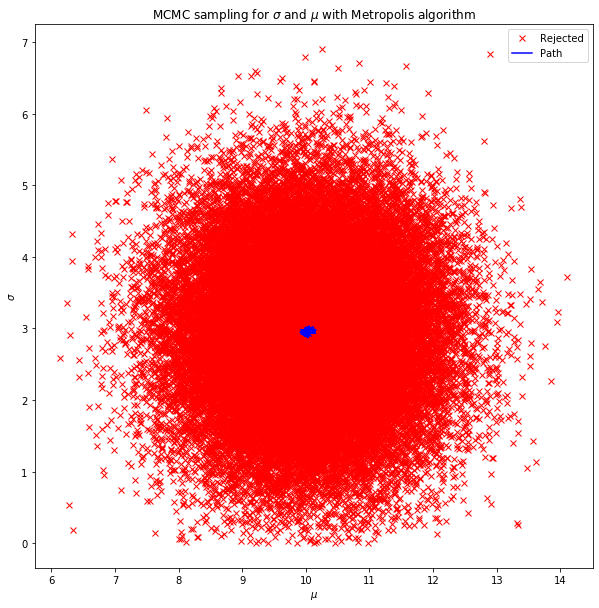

In [147]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
rejected_to_plot = rejected_idx[np.where(rejected_idx>50)]
accepted_to_plot = accepted_idx[np.where(accepted_idx>50)]
ax.plot(values[rejected_to_plot,0], values[rejected_to_plot,1], 'rx', label='Rejected')
ax.plot(values[accepted_to_plot,0], values[accepted_to_plot,1], 'b', label="Path")
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\sigma$")
ax.legend()
ax.set_title(r"MCMC sampling for $\sigma$ and $\mu$ with Metropolis algorithm")  

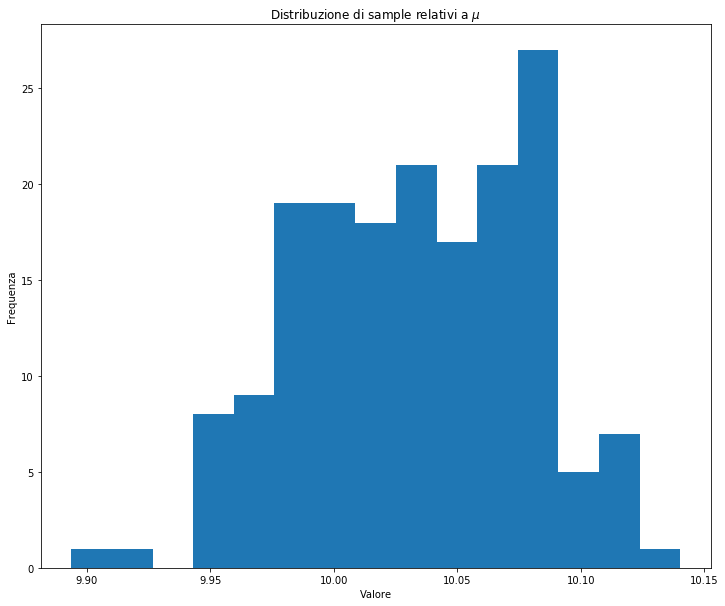

In [140]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.hist( values[accepted_to_plot,0],bins=15 ,)
ax.set_xlabel("Valore")
ax.set_ylabel("Frequenza")
ax.set_title("Distribuzione di sample relativi a $\mu$")
plt.show()

In [141]:
values[accepted_to_plot,0].mean()

10.032302727162886

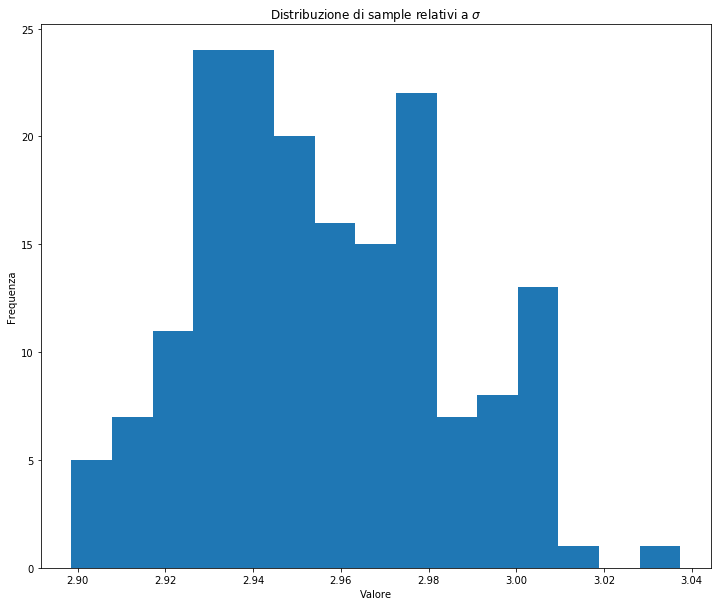

In [142]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.hist( values[accepted_to_plot,1],bins=15 ,)
ax.set_xlabel("Valore")
ax.set_ylabel("Frequenza")
ax.set_title("Distribuzione di sample relativi a $\sigma$")
plt.show()

In [143]:
values[accepted_to_plot,1].mean()

2.9554933531754166